# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-a9783fac-7b6d-815a-57bb-4a80251c01d1)


In [ ]:
import plotly.graph_objs as go
from google.colab import drive
import pandas as pd
import seaborn as sns
import plotly.offline as py
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn import metrics
import time

import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]

NumPy 1.21.6

TensorFlow 2.8.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
tf.random.set_seed(5678)


# 2. Prepare the data in NumPy 

Suppose that this example deals with the single-label multi-class classification problem where a single input is a 1D vector of shape (100,) and there are 10 predefined classes of output.

1. Load train and test data
2. Data preprocessing
3. Format the data (e.g, shape, dtype) to suit with the model's requirement (e.g., MLP)

In [ ]:
# Load Data from Google Drive

drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/DADS 7202 Deep Learning/02_Deep Learning_HW1_MLP/Data Set/hotel_bookings.csv')
data.shape


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(119390, 32)

In [ ]:
data['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [ ]:
data.drop(['company'],inplace=True,axis=1)
data['agent'].fillna(data['agent'].mode()[0],inplace=True)
data['country'].fillna(data['country'].mode()[0],inplace=True)
data['children'].fillna(data['children'].mean(),inplace=True)

In [ ]:
categorical_columns=[]
continuous_columns=[]
for col in data.columns:
    if data[col].dtype!='object':
        continuous_columns.append(col)
    else:
        categorical_columns.append(col)
    

In [ ]:
hotel_bookings_df=data

In [ ]:
hotel_bookings_df['arrival_date_month'] = hotel_bookings_df['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7,
                                                            'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
hotel_bookings_df['hotel'] = hotel_bookings_df['hotel'].map({'Resort Hotel':0, 'City Hotel':1})
hotel_bookings_df["total_members"] = hotel_bookings_df["adults"] + hotel_bookings_df["children"] + hotel_bookings_df["babies"]
hotel_bookings_df["total_stay"] = hotel_bookings_df["stays_in_weekend_nights"]+ hotel_bookings_df["stays_in_week_nights"]
hotel_bookings_df.drop(columns = ['adults', 'babies', 'children', 'stays_in_weekend_nights', 'stays_in_week_nights'],inplace=True,axis=1)

In [ ]:
le = LabelEncoder()
hotel_bookings_df['meal'] = le.fit_transform(hotel_bookings_df['meal'])
hotel_bookings_df['country'] = le.fit_transform(hotel_bookings_df['country'])
hotel_bookings_df['distribution_channel'] = le.fit_transform(hotel_bookings_df['distribution_channel'])
hotel_bookings_df['reserved_room_type'] = le.fit_transform(hotel_bookings_df['reserved_room_type'])
hotel_bookings_df['assigned_room_type'] = le.fit_transform(hotel_bookings_df['assigned_room_type'])
hotel_bookings_df['deposit_type'] = le.fit_transform(hotel_bookings_df['deposit_type'])
hotel_bookings_df['customer_type'] = le.fit_transform(hotel_bookings_df['customer_type'])
hotel_bookings_df['reservation_status'] = le.fit_transform(hotel_bookings_df['reservation_status'])
hotel_bookings_df['market_segment'] = le.fit_transform(hotel_bookings_df['market_segment'])
hotel_bookings_df['reservation_status_date'] = le.fit_transform(hotel_bookings_df['reservation_status_date'])
hotel_bookings_df['is_canceled'] = le.fit_transform(hotel_bookings_df['is_canceled'])

In [ ]:
hotel_bookings_df=hotel_bookings_df[['hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_members',
       'total_stay', 'is_canceled']]

In [ ]:
hotel_bookings_df.drop(['reservation_status'],inplace=True,axis=1)

In [ ]:
hotel_bookings_df.drop(['arrival_date_year','arrival_date_day_of_month','assigned_room_type'],inplace=True,axis=1)

In [ ]:
X = hotel_bookings_df.drop(["is_canceled"], axis=1)
y = hotel_bookings_df["is_canceled"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 64)

sm = SMOTE(random_state=64)
X_res, y_res = sm.fit_resample(X_train, y_train)
X_res_train,X_val , y_res_train, y_val = train_test_split(X_res, y_res, test_size = 0.30, random_state = 64)

In [ ]:
from collections import Counter

print('Resampled dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 75166, 1: 44224})
Resampled dataset shape Counter({0: 52524, 1: 52524})


# 3. Create the network architecture

In [ ]:
seednumber = [1,39,42,1234,5678]

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 12)                288       
                                                                 
 bn1 (BatchNormalization)    (None, 12)                48        
                                                                 
 hidden2 (Dense)             (None, 48)                624       
                                                                 
 bn2 (BatchNormalization)    (None, 48)                192       
                                                                 
 hidden3 (Dense)             (None, 64)                3136      
                                                                 
 bn3 (BatchNormalization)    (None, 64)                256       
                                                                 
 hidden4 (Dense)             (None, 48)              

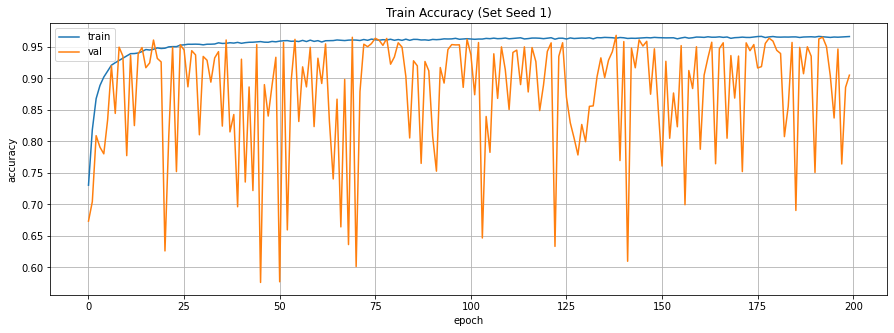

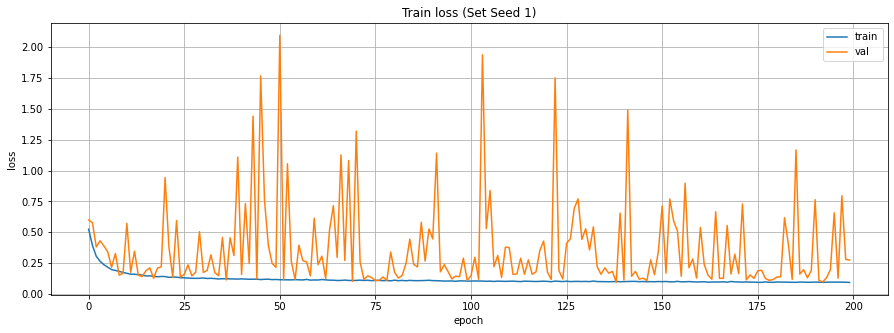

Epoch 1/200
368/368 [==============================] - 4s 9ms/step - loss: 0.1010 - acc: 0.9631 - auc_15: 0.9908 - val_loss: 0.1362 - val_acc: 0.9494 - val_auc_15: 0.9866
Epoch 2/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0999 - acc: 0.9639 - auc_15: 0.9909 - val_loss: 0.0941 - val_acc: 0.9683 - val_auc_15: 0.9917
Epoch 3/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0997 - acc: 0.9646 - auc_15: 0.9908 - val_loss: 0.1458 - val_acc: 0.9483 - val_auc_15: 0.9854
Epoch 4/200
368/368 [==============================] - 3s 8ms/step - loss: 0.1004 - acc: 0.9635 - auc_15: 0.9908 - val_loss: 0.1700 - val_acc: 0.9268 - val_auc_15: 0.9847
Epoch 5/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0976 - acc: 0.9654 - auc_15: 0.9911 - val_loss: 0.1252 - val_acc: 0.9501 - val_auc_15: 0.9874
Epoch 6/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0986 - acc: 0.9648 - auc_15: 0.9911 - val_loss: 0.2575 - val_acc: 0.

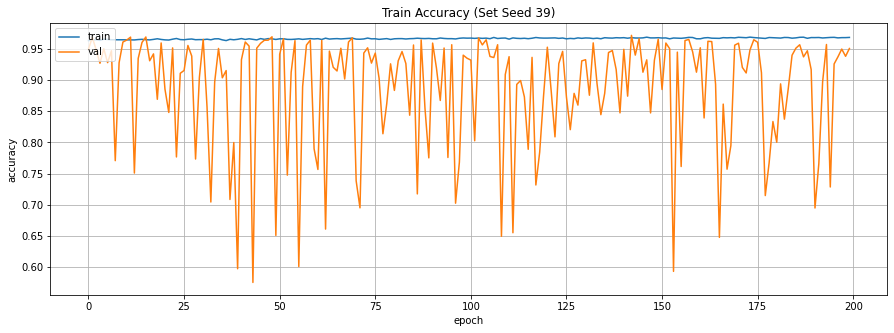

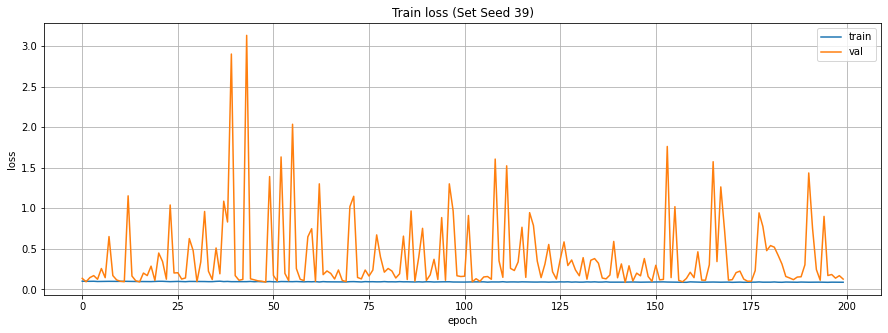

Epoch 1/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0900 - acc: 0.9676 - auc_15: 0.9923 - val_loss: 0.1209 - val_acc: 0.9532 - val_auc_15: 0.9891
Epoch 2/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0909 - acc: 0.9668 - auc_15: 0.9923 - val_loss: 0.3308 - val_acc: 0.9009 - val_auc_15: 0.9654
Epoch 3/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0921 - acc: 0.9664 - auc_15: 0.9923 - val_loss: 0.0970 - val_acc: 0.9666 - val_auc_15: 0.9912
Epoch 4/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0899 - acc: 0.9674 - auc_15: 0.9925 - val_loss: 0.3473 - val_acc: 0.8853 - val_auc_15: 0.9637
Epoch 5/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0897 - acc: 0.9679 - auc_15: 0.9925 - val_loss: 0.2353 - val_acc: 0.9077 - val_auc_15: 0.9828
Epoch 6/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0885 - acc: 0.9681 - auc_15: 0.9927 - val_loss: 0.1095 - val_acc: 0.

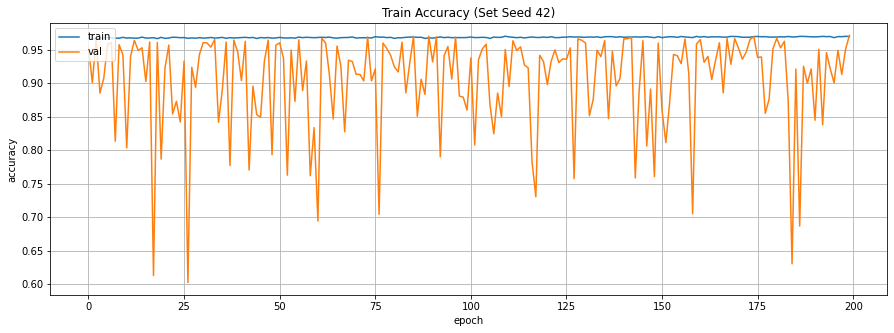

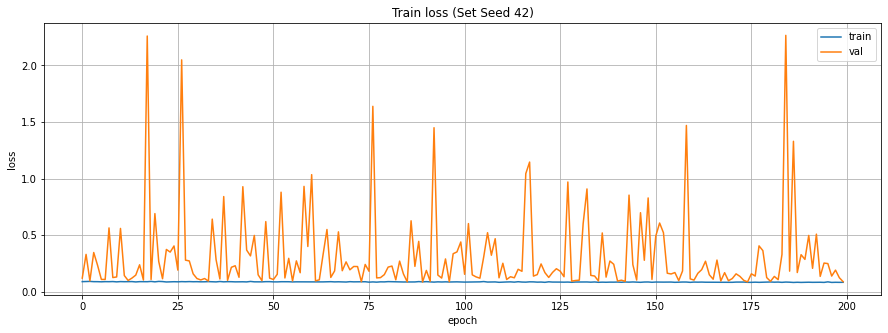

Epoch 1/200
368/368 [==============================] - 4s 9ms/step - loss: 0.0867 - acc: 0.9687 - auc_15: 0.9929 - val_loss: 0.5716 - val_acc: 0.8194 - val_auc_15: 0.9482
Epoch 2/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0843 - acc: 0.9694 - auc_15: 0.9933 - val_loss: 1.3120 - val_acc: 0.7342 - val_auc_15: 0.8594
Epoch 3/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0840 - acc: 0.9696 - auc_15: 0.9933 - val_loss: 0.5007 - val_acc: 0.8696 - val_auc_15: 0.9379
Epoch 4/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0868 - acc: 0.9688 - auc_15: 0.9929 - val_loss: 0.1038 - val_acc: 0.9602 - val_auc_15: 0.9911
Epoch 5/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0860 - acc: 0.9688 - auc_15: 0.9930 - val_loss: 0.1653 - val_acc: 0.9285 - val_auc_15: 0.9873
Epoch 6/200
368/368 [==============================] - 4s 10ms/step - loss: 0.0829 - acc: 0.9699 - auc_15: 0.9935 - val_loss: 0.1497 - val_acc: 0

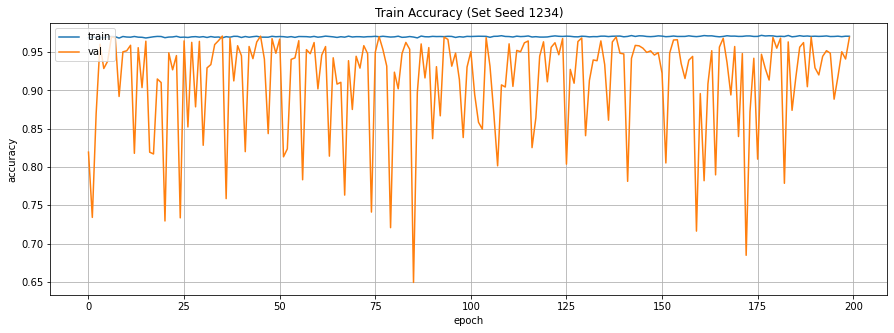

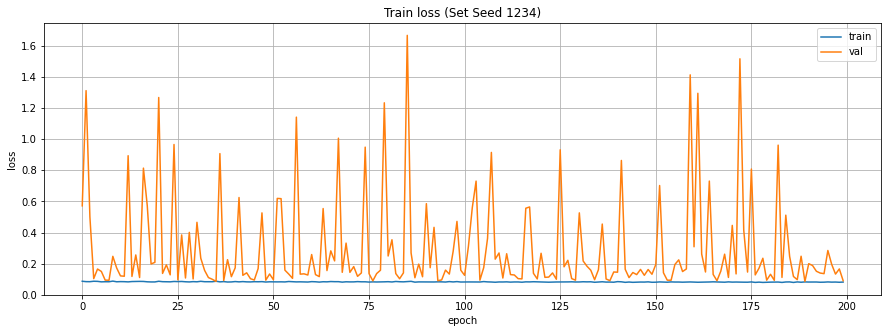

Epoch 1/200
368/368 [==============================] - 4s 9ms/step - loss: 0.0841 - acc: 0.9695 - auc_15: 0.9933 - val_loss: 0.9884 - val_acc: 0.8065 - val_auc_15: 0.9115
Epoch 2/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0865 - acc: 0.9685 - auc_15: 0.9930 - val_loss: 0.2796 - val_acc: 0.8892 - val_auc_15: 0.9835
Epoch 3/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0838 - acc: 0.9697 - auc_15: 0.9934 - val_loss: 0.3059 - val_acc: 0.8938 - val_auc_15: 0.9714
Epoch 4/200
368/368 [==============================] - 3s 8ms/step - loss: 0.0821 - acc: 0.9705 - auc_15: 0.9936 - val_loss: 0.3778 - val_acc: 0.8717 - val_auc_15: 0.9708
Epoch 5/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0834 - acc: 0.9695 - auc_15: 0.9934 - val_loss: 0.3978 - val_acc: 0.8652 - val_auc_15: 0.9600
Epoch 6/200
368/368 [==============================] - 3s 9ms/step - loss: 0.0835 - acc: 0.9700 - auc_15: 0.9934 - val_loss: 0.0862 - val_acc: 0.

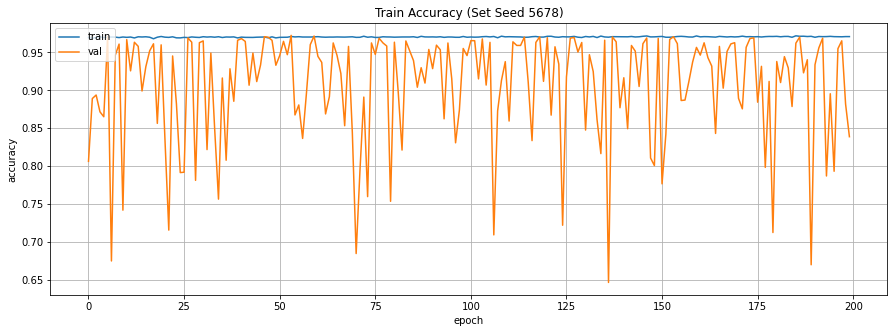

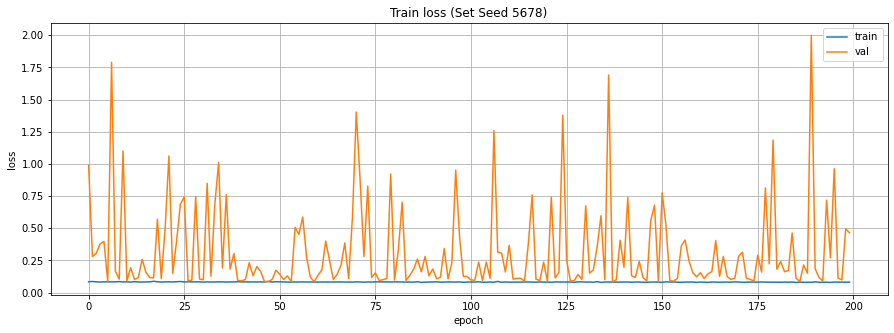

CPU times: user 1h 39s, sys: 5min 50s, total: 1h 6min 29s
Wall time: 55min 25s


In [ ]:
%%time
result = pd.DataFrame(columns=['set_seed','train_time','inference_time','auc_score'])
model = tf.keras.models.Sequential()

# Input layer
model.add( tf.keras.Input(shape=(23,)) )

# Hidden layer
model.add( tf.keras.layers.Dense(12, activation='relu', name='hidden1') )   # use default weight initialization, don't use any regularization
model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn1') )  
model.add( tf.keras.layers.Dense(48, activation='relu', name='hidden2') )   # use default weight initialization, don't use any regularization
model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn2') )
model.add( tf.keras.layers.Dense(64, activation='relu', name='hidden3') )   # use default weight initialization, don't use any regularization
model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn3') )
model.add( tf.keras.layers.Dense(48, activation='relu', name='hidden4') )   # use default weight initialization, don't use any regularization
model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn4') )
model.add( tf.keras.layers.Dense(12, activation='relu', name='hidden5') )   # use default weight initialization, don't use any regularization
model.add( tf.keras.layers.BatchNormalization(axis=-1, name='bn5') )
model.add( tf.keras.layers.Dense(1, activation='sigmoid', name='output') )   # use default weight initialization, don't use any regularization


model.summary()

model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
                    loss='binary_crossentropy' ,
                    metrics=['acc',tf.keras.metrics.AUC(from_logits=True)] 
                    )
    
for i in seednumber:
    tf.random.set_seed(i)

    checkpoint_filepath = "bestmodel_epoch.hdf5"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                                              save_weights_only=True,
                                                                                              monitor='val_acc',
                                                                                              mode='max',
                                                                                              save_best_only=True)
#-----------Train-------------
    train_start_time = time.time()
    history = model.fit( X_res_train, y_res_train, batch_size=200, epochs=200, verbose=1, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback] )
    train_end_time = time.time()
    
    inference_start_time = time.time()
    model.load_weights('/content/bestmodel_epoch.hdf5')
    y_pred = model.predict( X_res_train )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
    round_pred = [round(i[0],0) for i in y_pred]
    inference_end_time = time.time()

    fpr, tpr, thresholds = metrics.roc_curve(y_res_train.values.tolist(), round_pred)
    print('AUC score (Train)',metrics.auc(fpr, tpr))

    value_result = {'data':'train','set_seed':i,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr),'f1_class0':metrics.f1_score(y_res_train, round_pred, average=None)[0],'f1_class1':metrics.f1_score(y_res_train, round_pred, average=None)[1]}
    result = result.append(value_result,ignore_index=True)

#-----------Validation-------------
    inference_start_time = time.time()
    model.load_weights('/content/bestmodel_epoch.hdf5')
    y_pred = model.predict( X_val )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
    round_pred = [round(i[0],0) for i in y_pred]
    inference_end_time = time.time()

    fpr, tpr, thresholds = metrics.roc_curve(y_val.values.tolist(), round_pred)
    print('AUC score (Validation)',metrics.auc(fpr, tpr))

    value_result = {'data':'validation','set_seed':i,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr),'f1_class0':metrics.f1_score(y_val, round_pred, average=None)[0],'f1_class1':metrics.f1_score(y_val, round_pred, average=None)[1]}
    result = result.append(value_result,ignore_index=True)

#-----------Test-------------
    inference_start_time = time.time()
    model.load_weights('/content/bestmodel_epoch.hdf5')
    y_pred = model.predict( X_test )   # reshape x_test[i] from (n_feature,) to (1, n_feature)
    round_pred = [round(i[0],0) for i in y_pred]
    inference_end_time = time.time()

    fpr, tpr, thresholds = metrics.roc_curve(y_test.values.tolist(), round_pred)
    print('AUC score (Test)',metrics.auc(fpr, tpr))
    print(classification_report(y_test.values.tolist(),round_pred))

    value_result = {'data':'test','set_seed':i,'train_time':train_end_time - train_start_time,'inference_time':inference_end_time-inference_start_time,'auc_score':metrics.auc(fpr, tpr),'f1_class0':metrics.f1_score(y_test, round_pred, average=None)[0],'f1_class1':metrics.f1_score(y_test, round_pred, average=None)[1]}
    result = result.append(value_result,ignore_index=True)


    # Summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(f'Train Accuracy (Set Seed {i})')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

    # Summarize history for loss
    plt.figure(figsize=(15,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Train loss (Set Seed {i})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.grid()
    plt.show()


# 6. Evaluate the model on test set

In [ ]:
result

,set_seed,train_time,inference_time,auc_score,data,f1_class0,f1_class1
0,1,623.898820,3.634488,0.968977,train,0.969585,0.968237
1,1,623.898820,2.657773,0.968209,validation,0.969234,0.967377
2,1,623.898820,1.786352,0.968848,test,0.980726,0.965694
3,39,637.038019,5.322920,0.972084,train,0.972549,0.971512
4,39,637.038019,2.663448,0.971400,validation,0.972224,0.970749
5,39,637.038019,2.669006,0.972343,test,0.982534,0.969135
6,42,682.250116,3.437569,0.972014,train,0.972446,0.971481
7,42,682.250116,1.537628,0.971410,validation,0.972171,0.970808
8,42,682.250116,2.676720,0.972626,test,0.982451,0.969075
9,1234,655.934135,3.483209,0.972216,train,0.972784,0.971511


In [ ]:
result[['data','train_time','inference_time','auc_score','f1_class0','f1_class1']].groupby('data').agg(['mean','std']).reset_index()

data  train_time            inference_time           auc_score  \
                     mean        std           mean       std      mean   
0        test  656.271313  26.301367       2.122258  0.503075  0.971533   
1       train  656.271313  26.301367       3.860897  0.821508  0.971718   
2  validation  656.271313  26.301367       1.988685  0.613523  0.970808   

            f1_class0           f1_class1            
        std      mean       std      mean       std  
0  0.001802  0.982047  0.000758  0.968239  0.001442  
1  0.001619  0.972199  0.001534  0.971125  0.001722  
2  0.001560  0.971661  0.001429  0.970129  0.001677

# 7. Inference

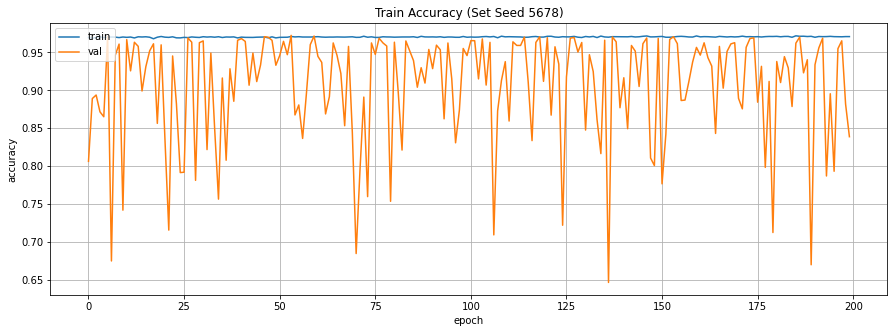

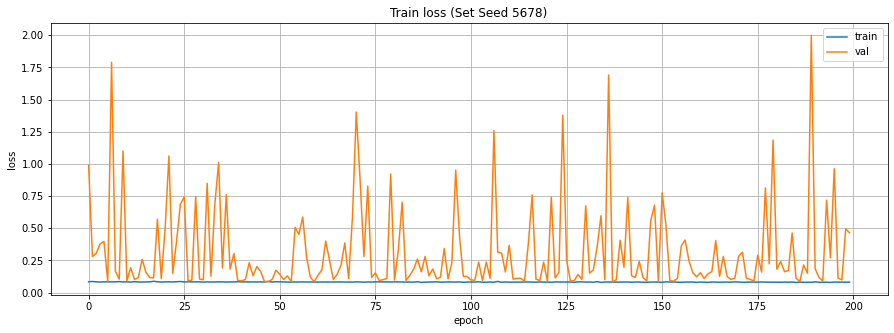

In [ ]:
# Summarize history for accuracy
# Seed 5678
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title(f'Train Accuracy (Set Seed {i})')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Train loss (Set Seed {i})')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()
